# Export Data for Web Application 

In [1]:
from cflp_function import cflp, plot_result, store_data_to_pickle, load_data_from_pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import json
# import pickle
# import os

%matplotlib inline

In [2]:
# version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [3]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [4]:
# Define the capacities of digester
medium_digester_capacity = 15056  # in tonne/yr
large_digester_capacity = 200000  # in tonne/yr

# Define the costs of digester 
medium_digester_cost = 252616   # in euro CAPEX
large_digester_cost = 12000000    # in euro CAPEX

In [5]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [22]:
# Create mock digester capacity data 
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, medium_digester_capacity, large_digester_capacity]

# Create mock digester cost data (f_j)
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, medium_digester_cost, large_digester_cost]

In [23]:
# (q_j)
max_capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500}
# (f_j)
fixed_cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [24]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [25]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # set F
Plant = potential_digester_location.index.tolist() # set P

In [26]:
# (p_i)
manure_production = farm['manure_t'].to_dict()  

# Define the total manure production by all farms (alpha)
total_manure = sum(manure_production[i] for i in Farm)

In [27]:
# # Open the file for reading
# with open("./transportation_cost.txt", "r") as fp:
#     # Load the dictionary from the file
#     transport_cost = json.load(fp)

# # Function to recursively convert dictionary keys to integers
# def convert_keys_to_int(data):
#     if isinstance(data, dict):
#         return {int(key) if key.isdigit() else key: convert_keys_to_int(value) for key, value in data.items()}
#     else:
#         return data

# # Convert the keys to integers
# transport_cost = convert_keys_to_int(transport_cost) # C_ij

In [28]:
# for key, value in transport_cost.items():
#     print(f"{key}: {value}")

In [29]:
folder_path = 'app_data'

In [30]:
# Export files

# List
store_data_to_pickle(Farm, folder_path, 'Farm.pickle') # set F
# store_data_to_pickle(Plant, folder_path, 'Plant.pickle') # set P

# Dictionary 
store_data_to_pickle(manure_production, folder_path, 'manure_production.pickle') # p_i 
store_data_to_pickle(max_capacity, folder_path, 'max_capacity.pickle') # q_j
store_data_to_pickle(fixed_cost, folder_path, 'fixed_cost.pickle') # f_j

# C_ij 

# Float
store_data_to_pickle(total_manure, folder_path, 'total_manure.pickle') # alpha

In [31]:
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost.pickle')

In [32]:
for key, value in transport_cost.items():
    print(f"{key}: {value}")

0: {0: 16.822292415186183, 1: 30.92678676733662, 2: 23.080232076563743, 3: 33.11418499953114, 4: 29.356686731100446, 5: 27.41710293178537, 6: 27.41710293178537, 7: 27.41710293178537, 8: 28.393829138915116, 9: 20.243105076787128, 10: 41.9612403626698, 11: 24.694036491927427, 12: 24.694036491927427, 13: 24.694036491927427, 14: 6.069888650558055, 15: 6.041608434693484, 16: 3.6984204997384635, 17: 4.749865433194389, 18: 4.800831043411421, 19: 6.9265145012485725, 20: 8.379585194747122, 21: 30.92678676733662, 22: 28.662957735301266, 23: 4.337480138541471, 24: 12.376571362498016, 25: 20.83828686389431, 26: 10.127768119498189, 27: 11.623676101427407, 28: 12.380453853312831, 29: 8.77946693119841, 30: 15.658359298495212, 31: 19.95668779518618, 32: 31.395057232114276, 33: 17.261318975042318, 34: 17.929386750054004, 35: 24.739822426244267, 36: 25.019588446244263, 37: 17.045507814370396, 38: 21.44247636432336, 39: 14.49822946887925, 40: 10.988322125436566, 41: 12.073425355643696, 42: 12.07342535564

## CFLP Model
* cflp: the cflp model
* find_farm_not_in_solution_plant_in_solution: disaggregating outputs for result visualization 
* plot_result: plot optimal solution (calls the previous function)

In [38]:
# Define manure use goal (mu)
target = 0.8

In [39]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/6998ce88a652427ba0f7fab5470b3aab-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/6998ce88a652427ba0f7fab5470b3aab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Solution Status =  Infeasible


In [35]:
# Check if the opened plants are under-utilized
total_sum_list = [sum(farm.loc[i, 'manure_t'] for i in value) for value in assignment_decision.values()]

potential_digester_location['allocated_manure'] = total_sum_list

# Find the percentage of plant's capacity that is utilized
potential_digester_location['underutilized'] = 0
mask = potential_digester_location['allocated_manure'] > 0
potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100
potential_digester_location

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_12186/1231458137.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.258 23.483]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100


,x,y,capacity,cost,allocated_manure,underutilized
0,6.870686,52.215190,15056,252616,0,0.000
1,6.554937,52.254895,15056,252616,0,0.000
2,6.730518,52.252885,200000,12000000,199484,0.258
3,6.914234,52.387401,15056,252616,0,0.000
4,6.664105,52.392622,200000,12000000,153034,23.483


In [36]:
filename = f"./outputs/cflp_v{6}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


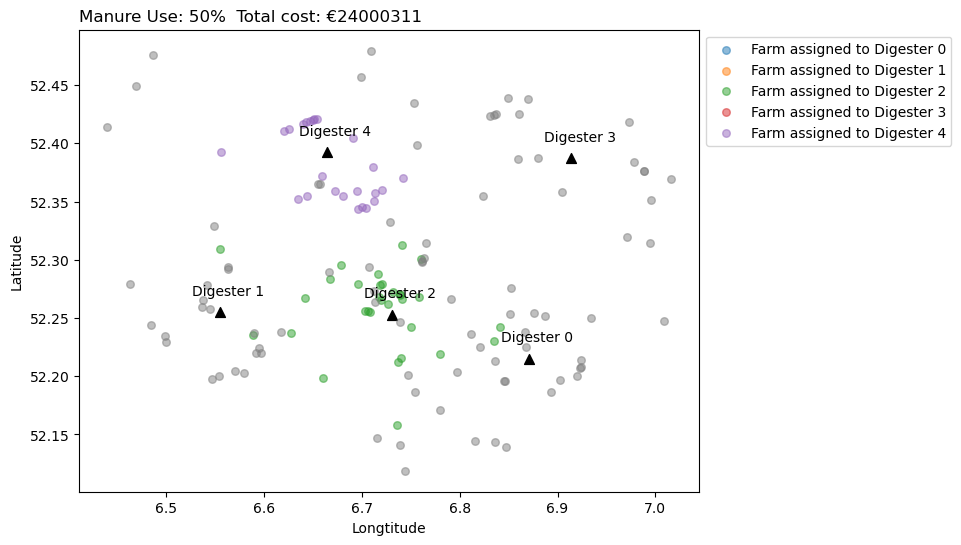

In [37]:
plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False)

In [46]:
import folium

In [50]:
farm

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0
...,...,...,...,...,...,...
137,277,6.717715,52.267689,507802,7102,2769780.0
138,278,6.642151,52.267548,507805,5988,2335320.0
139,279,6.627751,52.237078,507807,4814,1877460.0
140,280,6.716810,52.287837,507809,8090,3155100.0


In [ ]:
for lat, long in zip(farm.y, farm.x):
    folium.Marker(
        location=[lat, long], 
        icon=folium.Icon(icon_color='white')
    ).add_to(map)

In [51]:
center_map_coords = [52.40659843013704, 6.485187055207251]
map = folium.Map(location=center_map_coords, zoom_start=10, tiles='OpenStreetMap')
for lat, long in zip(farm.y, farm.x):
    folium.Marker(
        location=[lat, long], 
        icon=folium.Icon(icon_color='white')
    ).add_to(map)
map